In [2]:
import tensorflow as tf
import numpy as np
import h5py
from tqdm import tqdm

def reshape_outputs(img_shape=(32, 32)):
    def reshaping(inputs, targets):
        targets = tf.image.resize(targets, img_shape)
        targets = tf.math.ceil(targets)
        return inputs, targets

    return reshaping


def parse_function(img_shape=(128, 128, 1), test=False, clip=True):
    """

    :param img_shape:
    :param test:
    :param clip:
    :return:
    """
    def parsing(example_proto):
        keys_to_features = {'x': tf.io.FixedLenFeature(shape=img_shape, dtype=tf.float32),
                            'y': tf.io.FixedLenFeature(shape=img_shape, dtype=tf.int64)}
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_features)
        parsed_features['y'] = tf.cast(parsed_features['y'], tf.float32)
        if clip:
            parsed_features['x'] = tf.clip_by_value(parsed_features['x'], -166.43, 169.96)
        if test:
            return parsed_features['x']
        else:
            return parsed_features['x'], parsed_features['y']

    return parsing

def get_shape_of_quadratic_image_tfrecord(raw_dataset):
    keys_to_features = {'x': tf.io.VarLenFeature(dtype=tf.float32),
                        'y': tf.io.VarLenFeature(dtype=tf.int64)}
    for i in raw_dataset.take(1):
        parsed_features = tf.io.parse_single_example(i, keys_to_features)
        return int(np.sqrt(parsed_features["x"].shape[0])), int(np.sqrt(parsed_features["x"].shape[0])), 1

dataset = tf.data.TFRecordDataset(["../DATA1/val.tfrecord"])
tfrecord_shape = get_shape_of_quadratic_image_tfrecord(dataset)

In [3]:
parse_fn = parse_function(img_shape=tfrecord_shape, test=False, clip=True)

# 1) load & parse
raw_ds = (
    tf.data.TFRecordDataset(["../DATA1/val.tfrecord"])
      .map(parse_fn, num_parallel_calls=tf.data.AUTOTUNE)
)

# 2) shuffle deterministically so val/train are randomized but non-overlapping
#    buffer_size should be >= total needed (20000)
shuffled = raw_ds.shuffle(buffer_size=20000, seed=42, reshuffle_each_iteration=False)

# 3) split
val_ds   = shuffled.take(5000)
train_ds = shuffled.skip(5000)

# 4) from the train pool, build pos/neg subsets
pos_ds = train_ds.filter(lambda x,y: tf.reduce_any(tf.equal(y,1)))
neg_ds = train_ds.filter(lambda x,y: tf.reduce_all(tf.equal(y,0)))

# 5) take exactly 7500 of each, concat & final shuffle
pos_subset = pos_ds.take(7500)
neg_subset = neg_ds.take(7500)
final_train = (
    pos_subset
      .concatenate(neg_subset)
      .shuffle(buffer_size=15000, seed=123)  # optional extra shuffle
      .prefetch(tf.data.AUTOTUNE)
)

# 6) write TRAIN h5
# unpack tfrecord_shape = (H, W, 1)
H, W, C_in = tfrecord_shape

# but we want C_out=1 in the HDF5 (you could keep C_in if it's already 1)
C = 1

shape    = (0, C, H, W)
maxshape = (None, C, H, W)
chunks   = (1, C, H, W)

with h5py.File("train.h5", "w") as f_tr:
    dsx_tr = f_tr.create_dataset(
        "x",
        shape=shape,
        maxshape=maxshape,
        chunks=chunks,
        dtype=np.float32,
    )
    dsy_tr = f_tr.create_dataset(
        "y",
        shape=shape,
        maxshape=maxshape,
        chunks=chunks,
        dtype=np.float32,
    )

    for i, (x_tf, y_tf) in enumerate(tqdm(final_train, desc="Writing TRAIN")):
        x_np = np.transpose(x_tf.numpy(), (2, 0, 1))  # (1, H, W)
        y_np = np.transpose(y_tf.numpy(), (2, 0, 1))

        dsx_tr.resize(i + 1, axis=0)
        dsy_tr.resize(i + 1, axis=0)
        dsx_tr[i] = x_np
        dsy_tr[i] = y_np


    print(f"Finished TRAIN: {dsx_tr.shape[0]} examples")

# 7) write VAL h5
# Unpack your tfrecord_shape
H, W, C_in = tfrecord_shape
C = 1      # number of channels in HDF5

shape    = (0, C, H, W)
maxshape = (None, C, H, W)
chunks   = (1, C, H, W)

with h5py.File("val.h5", "w") as f_val:
    dsx_v = f_val.create_dataset(
        "x",
        shape=shape,
        maxshape=maxshape,
        chunks=chunks,
        dtype=np.float32,
    )
    dsy_v = f_val.create_dataset(
        "y",
        shape=shape,
        maxshape=maxshape,
        chunks=chunks,
        dtype=np.float32,
    )

    for i, (x_tf, y_tf) in enumerate(tqdm(val_ds, desc="Writing VAL")):
        x_np = np.transpose(x_tf.numpy(), (2, 0, 1))  # (C=1, H, W)
        y_np = np.transpose(y_tf.numpy(), (2, 0, 1))

        dsx_v.resize(i + 1, axis=0)
        dsy_v.resize(i + 1, axis=0)
        dsx_v[i] = x_np
        dsy_v[i] = y_np

    print(f"Finished VAL: stored {dsx_v.shape[0]} examples")

Writing TRAIN: 0it [00:00, ?it/s]2025-05-20 13:00:39.466346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 1 of 15000
2025-05-20 13:00:59.406159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 1032 of 15000
2025-05-20 13:01:09.425991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 1588 of 15000
2025-05-20 13:01:29.424385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 2709 of 15000
2025-05-20 13:01:49.421172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 3813 of 15000
2025-05-20 13:02:09.419923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Fil

Finished TRAIN: 15000 examples


Writing VAL: 4926it [00:01, 5728.16it/s]2025-05-20 13:03:25.334566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Writing VAL: 5000it [00:01, 3820.50it/s]


Finished VAL: stored 5000 examples


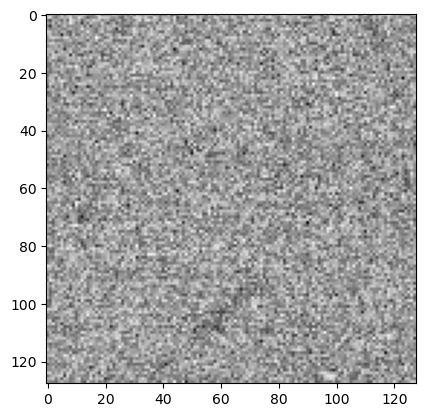

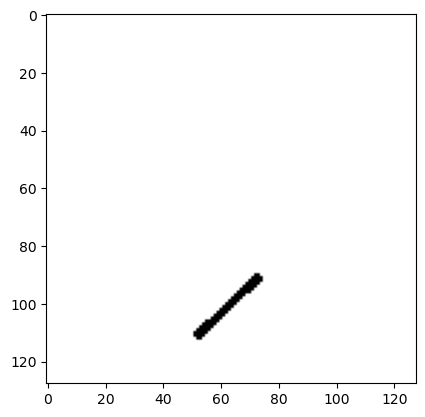

P/N ratio 0.0023487818436003414
N/P ratio 425.75260990060497


In [41]:
with h5py.File("train.h5", "r") as f:
    # f["x"] and f["y"] are h5py.Dataset objects
    X = f["x"][:]   # loads shape (15000, 1, H, W) into RAM
    Y = f["y"][:]   # same shape for labels
i = np.unique(np.argwhere(Y == 1)[:, 0])[11]
plt.imshow(X[i, 0], cmap="Grays")
plt.show()
plt.imshow(Y[i, 0], cmap="Grays")
plt.show()
print ("P/N ratio", (Y==1).sum()/(Y==0).sum())
print ("N/P ratio", (Y==0).sum()/(Y==1).sum())

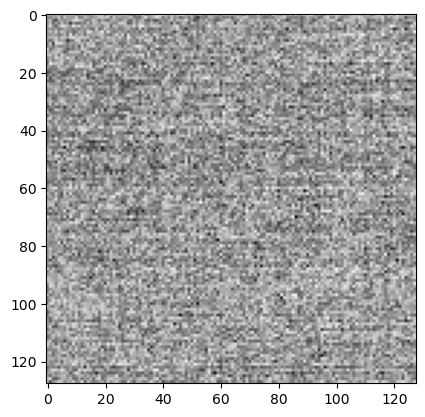

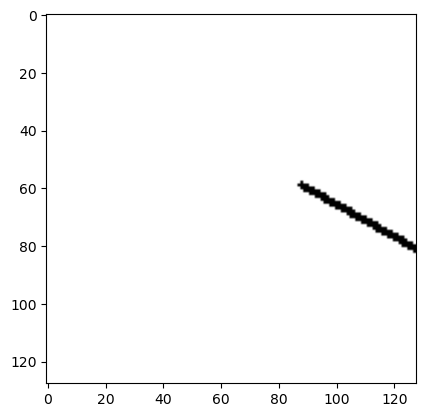

P/N ratio 0.00013547977806515124
N/P ratio 7381.175362710643


In [42]:
with h5py.File("val.h5", "r") as f:
    # f["x"] and f["y"] are h5py.Dataset objects
    X = f["x"][:]   # loads shape (15000, 1, H, W) into RAM
    Y = f["y"][:]   # same shape for labels
i = np.unique(np.argwhere(Y == 1)[:, 0])[11]
plt.imshow(X[i, 0], cmap="Grays")
plt.show()
plt.imshow(Y[i, 0], cmap="Grays")
plt.show()
print ("P/N ratio", (Y==1).sum()/(Y==0).sum())
print ("N/P ratio", (Y==0).sum()/(Y==1).sum())

(array([ 490295.,   38831.,   41953.,   45245.,   47435.,   50660.,
          54042.,   57661.,   62649.,   66577.,   72219.,   76869.,
          82159.,   88927.,   95996.,  104195.,  112802.,  123345.,
         134549.,  147076.,  162401.,  181029.,  200208.,  224305.,
         252208.,  285901.,  321821.,  365644.,  416938.,  476325.,
         539432.,  615431.,  697664.,  794912.,  895282., 1008964.,
        1134921., 1269883., 1417109., 1576722., 1748123., 1931564.,
        2128322., 2330050., 2538845., 2737980., 2905316., 3059356.,
        3169759., 5591104., 3201940., 3062415., 2908121., 2726874.,
        2535196., 2334830., 2140925., 1952595., 1772973., 1607101.,
        1455749., 1310613., 1177878., 1055988.,  943979.,  837261.,
         744496.,  660898.,  586737.,  519393.,  461468.,  408915.,
         362310.,  321963.,  287401.,  257783.,  232001.,  208698.,
         189492.,  172418.,  158040.,  143919.,  133044.,  122324.,
         113705.,  104424.,   97772.,   91147., 

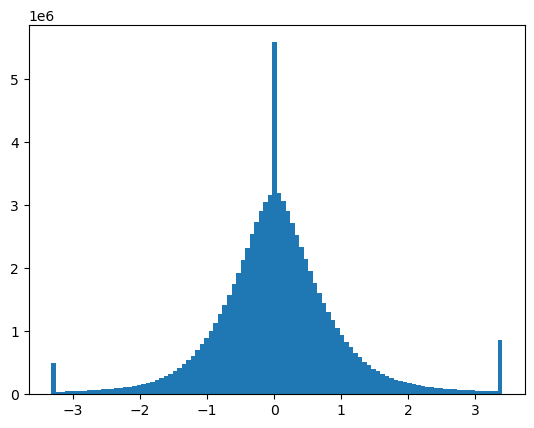

In [53]:
plt.hist(X.flatten()/50, bins=100)

In [52]:
X.flatten().std()

47.859386

In [50]:
X[Y==0].max()

169.96

In [48]:
X.min()

-166.43